### Imports and Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.decomposition import PCA, KernelPCA
import umap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from utils.models import model_mapping
from utils.evaluate import evaluate_model
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# suppressing OpenMP warnings that aren't necessary
os.environ["KMP_WARNINGS"] = "0"
warnings.filterwarnings("ignore", message=".*omp_set_nested routine deprecated.*")

# suppressing warnings that aren't critical   
warnings.filterwarnings("ignore", message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*")
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden to 1 by setting random_state.*")

### Loading Best Model

In [2]:
with open("./data/best_model.txt", "r") as file:
    best_model_name = file.readline().strip().replace("Best Model: ", "")
         
if best_model_name in model_mapping:
    optimal_model = model_mapping[best_model_name]()
    display(Markdown(f"Using **{best_model_name}** as the best model for feature evaluation."))
else:
    raise ValueError(f"Model '{best_model_name}' not found in model_mapping. Please check best_model.txt.")

Using **Non-linear SVM** as the best model for feature evaluation.

### Dummy Data

In [3]:
X, y = make_classification(n_samples=500, n_features=5000, n_informative=100, 
                           n_redundant=50, random_state=42)
X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

# split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

### Encoding, Scaling, and Feature Prep

In [4]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

feature_counts = [1] + list(range(10, 201, 10)) # official
#feature_counts = [1, 100, 200] # for temporary convenience
feature_selection_results = {}
feature_extraction_results = {}

best_model = optimal_model

### Feature Selection Methods

In [5]:
def select_features(X_train, y_train, X_test, method, k=100):
    selector = SelectKBest(method, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected

print(f"Evaluating Feature Selection with:")

for k in feature_counts:
    print(f"{k} features")
    
    # selecting the features
    X_train_chi2, X_test_chi2 = select_features(X_train_scaled, y_train, X_test_scaled, chi2, k)
    X_train_mi, X_test_mi = select_features(X_train_scaled, y_train, X_test_scaled, mutual_info_classif, k)
    X_train_anova, X_test_anova = select_features(X_train_scaled, y_train, X_test_scaled, f_classif, k)

    # training the model
    best_model.train(X_train_chi2, y_train)
    chi2_pred_probs = best_model.model.predict_proba(X_test_chi2)[:, 1]
    
    best_model.train(X_train_mi, y_train)
    mi_pred_probs = best_model.model.predict_proba(X_test_mi)[:, 1]
    
    best_model.train(X_train_anova, y_train)
    anova_pred_probs = best_model.model.predict_proba(X_test_anova)[:, 1]

    # storing results
    feature_selection_results[k] = { 
        "Chi-Squared": evaluate_model(y_test, chi2_pred_probs.round(), chi2_pred_probs),
        "Mutual Information": evaluate_model(y_test, mi_pred_probs.round(), mi_pred_probs),
        "ANOVA F-value": evaluate_model(y_test, anova_pred_probs.round(), anova_pred_probs)
    }

Evaluating Feature Selection with:
1 features
10 features
20 features
30 features
40 features
50 features
60 features
70 features
80 features
90 features
100 features
110 features
120 features
130 features
140 features
150 features
160 features
170 features
180 features
190 features
200 features


### Feature Extraction Methods

In [6]:
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca
    
print(f"Evaluating Feature Extraction with:")

model_predictor = next(
    getattr(best_model, attr) for attr in dir(best_model)
    if hasattr(getattr(best_model, attr), 'predict_proba')
)
    
for n in feature_counts:
    print(f"{n} components")
    
    # application of extraction models
    X_train_pca, X_test_pca = apply_pca(X_train_scaled, X_test_scaled, n)
    
    kpca = KernelPCA(n_components=n, kernel='rbf')
    X_train_kpca = kpca.fit_transform(X_train_scaled)
    X_test_kpca = kpca.transform(X_test_scaled)
    
    umap_reducer = umap.UMAP(n_components=n, random_state=42)
    X_train_umap = umap_reducer.fit_transform(X_train_scaled)
    X_test_umap = umap_reducer.transform(X_test_scaled)

    # training the model
    best_model.train(X_train_pca, y_train)
    pca_pred_probs = best_model.model.predict_proba(X_test_pca)[:, 1]
    
    best_model.train(X_train_kpca, y_train)
    kpca_pred_probs = best_model.model.predict_proba(X_test_kpca)[:, 1]
    
    best_model.train(X_train_umap, y_train)
    umap_pred_probs = best_model.model.predict_proba(X_test_umap)[:, 1]

    # storing results
    feature_extraction_results[n] = { 
        "PCA": evaluate_model(y_test, pca_pred_probs.round(), pca_pred_probs),
        "Kernel PCA": evaluate_model(y_test, kpca_pred_probs.round(), kpca_pred_probs),
        "UMAP": evaluate_model(y_test, umap_pred_probs.round(), umap_pred_probs)
    }

Evaluating Feature Extraction with:
1 components
10 components
20 components
30 components
40 components
50 components
60 components
70 components
80 components
90 components
100 components
110 components
120 components
130 components
140 components
150 components
160 components
170 components
180 components
190 components
200 components


### Printing Results

In [7]:
metric_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]

# metrics into columns
def expand_results(results_dict):
    expanded_results = {}
    for k, v in results_dict.items():
        for method, metrics in v.items():
            expanded_results[(k, method)] = metrics
    return expanded_results

df_feature_selection = pd.DataFrame.from_dict(expand_results(feature_selection_results), orient='index', columns=metric_names)
df_feature_extraction = pd.DataFrame.from_dict(expand_results(feature_extraction_results), orient='index', columns=metric_names)

df_feature_selection.index.name = "# of Selected Features, Method"
df_feature_extraction.index.name = "# of Components, Method"

display(Markdown("#### Feature Selection Results:"))
display(df_feature_selection)

display(Markdown("#### Feature Extraction Results:"))
display(df_feature_extraction)

#### Feature Selection Results:

,Accuracy,Precision,Recall,F1,AUC
"# of Selected Features, Method",,,,,
"(1, Chi-Squared)",0.58,0.594982,0.58,0.578992,0.642424
"(1, Mutual Information)",0.45,0.202500,0.45,0.279310,0.524040
"(1, ANOVA F-value)",0.61,0.643316,0.61,0.603277,0.641818
"(10, Chi-Squared)",0.68,0.698409,0.68,0.679232,0.760808
"(10, Mutual Information)",0.46,0.508303,0.46,0.357261,0.497778
...,...,...,...,...,...
"(190, Mutual Information)",0.59,0.590862,0.59,0.590372,0.632727
"(190, ANOVA F-value)",0.71,0.715000,0.71,0.710727,0.752323
"(200, Chi-Squared)",0.66,0.658874,0.66,0.659172,0.745455


#### Feature Extraction Results:

,Accuracy,Precision,Recall,F1,AUC
"# of Components, Method",,,,,
"(1, PCA)",0.46,0.570790,0.46,0.316804,0.516970
"(1, Kernel PCA)",0.55,0.528061,0.55,0.407384,0.445051
"(1, UMAP)",0.45,0.202500,0.45,0.279310,0.499394
"(10, PCA)",0.53,0.547500,0.53,0.526466,0.554747
"(10, Kernel PCA)",0.46,0.754545,0.46,0.300893,0.602020
...,...,...,...,...,...
"(190, Kernel PCA)",0.61,0.632500,0.61,0.607068,0.664646
"(190, UMAP)",0.46,0.464066,0.46,0.461301,0.446869
"(200, PCA)",0.45,0.202500,0.45,0.279310,0.391111


### Bar Chart

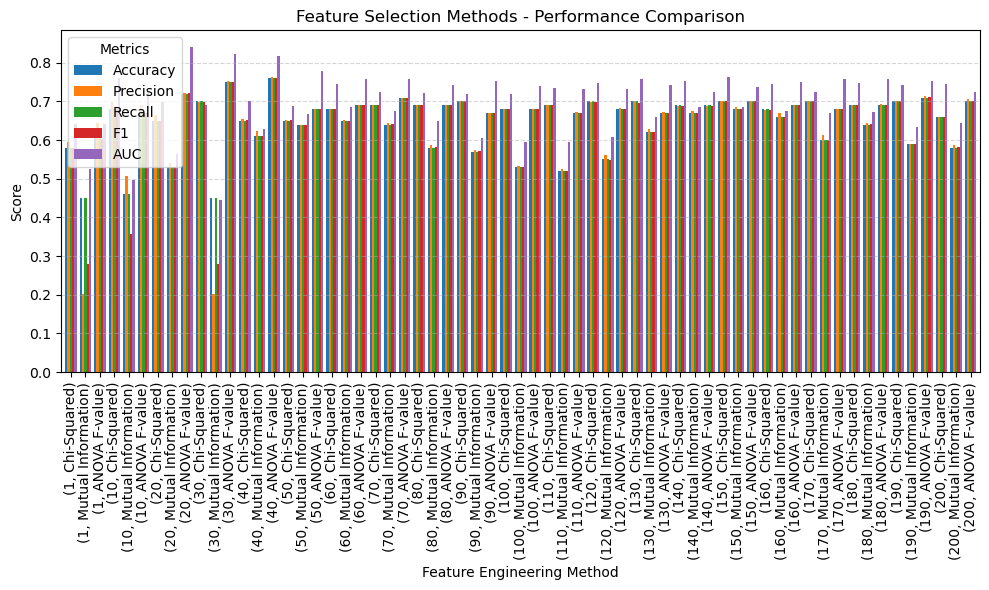

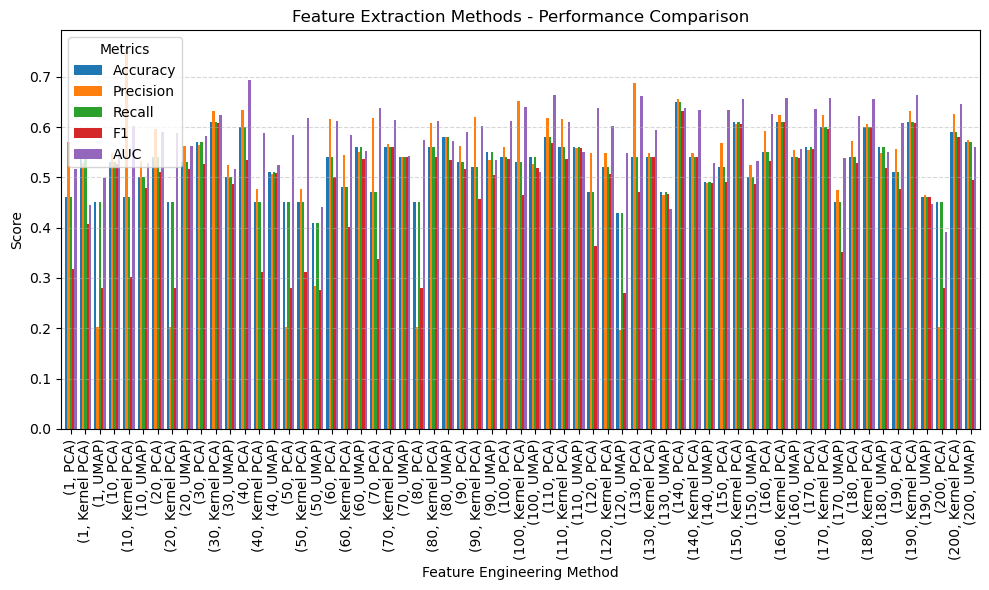

In [8]:
import matplotlib.pyplot as plt

def plot_bar_chart(df, title):
    ax = df.plot(kind='bar', figsize=(10, 6), width=0.8)
    plt.title(title)
    plt.xlabel('Feature Engineering Method')
    plt.ylabel('Score')
    plt.legend(title='Metrics')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_bar_chart(df_feature_selection, "Feature Selection Methods - Performance Comparison")

plot_bar_chart(df_feature_extraction, "Feature Extraction Methods - Performance Comparison")


### Heatmap

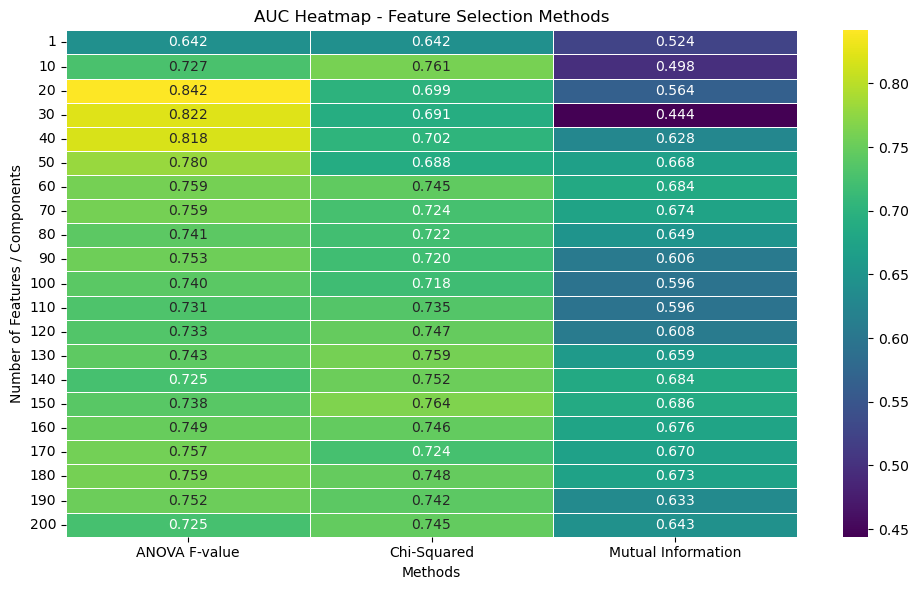

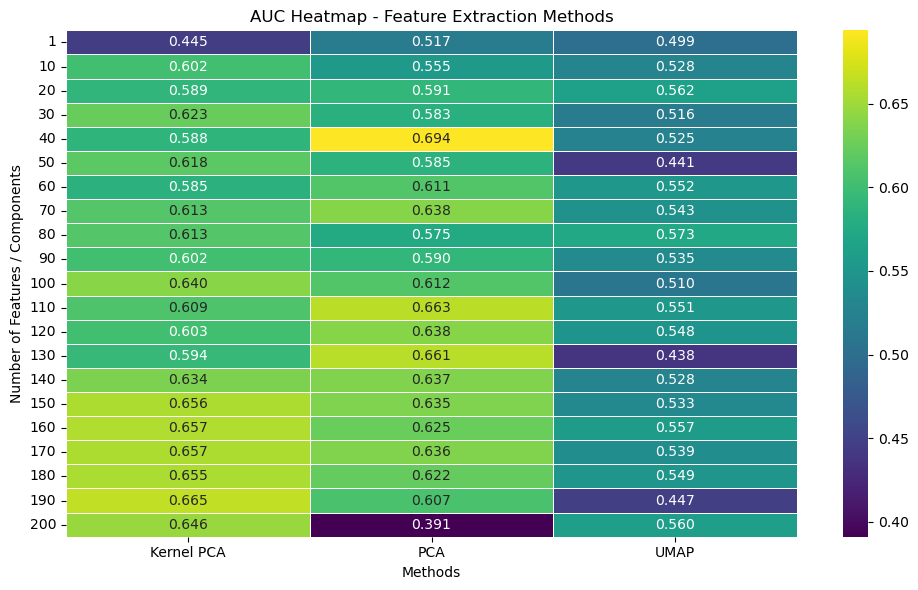

In [9]:
df_feature_selection.index = pd.MultiIndex.from_tuples(df_feature_selection.index, names=["# of Features", "Method"])
df_feature_extraction.index = pd.MultiIndex.from_tuples(df_feature_extraction.index, names=["# of Components", "Method"])

def plot_heatmap(df, title):
    heatmap_data = df['AUC'].unstack(level=1)

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".3f", linewidths=0.5)
    
    plt.title(title)
    plt.xlabel("Methods")
    plt.ylabel("Number of Features / Components")
    plt.tight_layout()
    plt.show()

plot_heatmap(df_feature_selection, "AUC Heatmap - Feature Selection Methods")
plot_heatmap(df_feature_extraction, "AUC Heatmap - Feature Extraction Methods")


### Line Chart

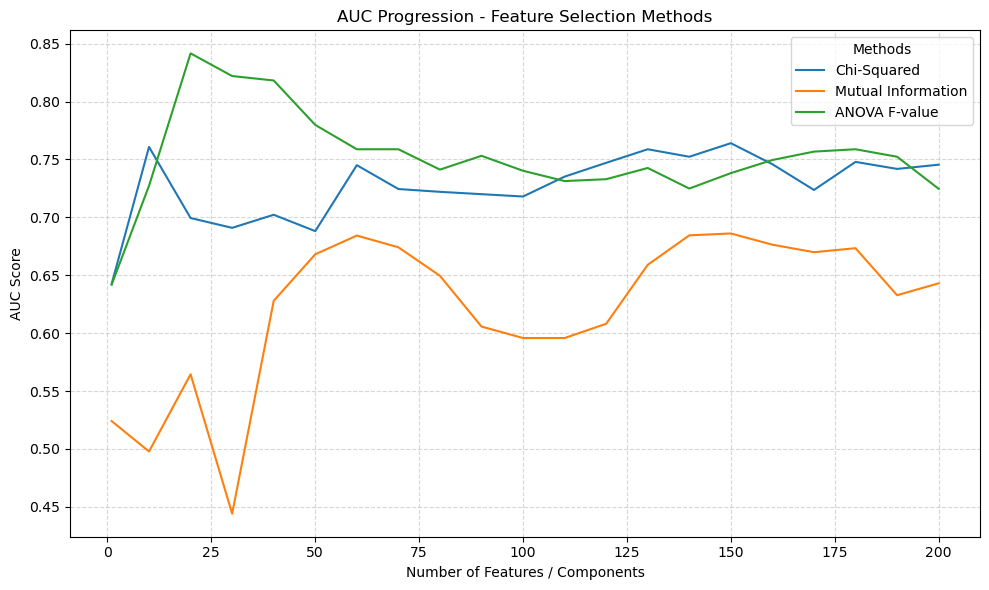

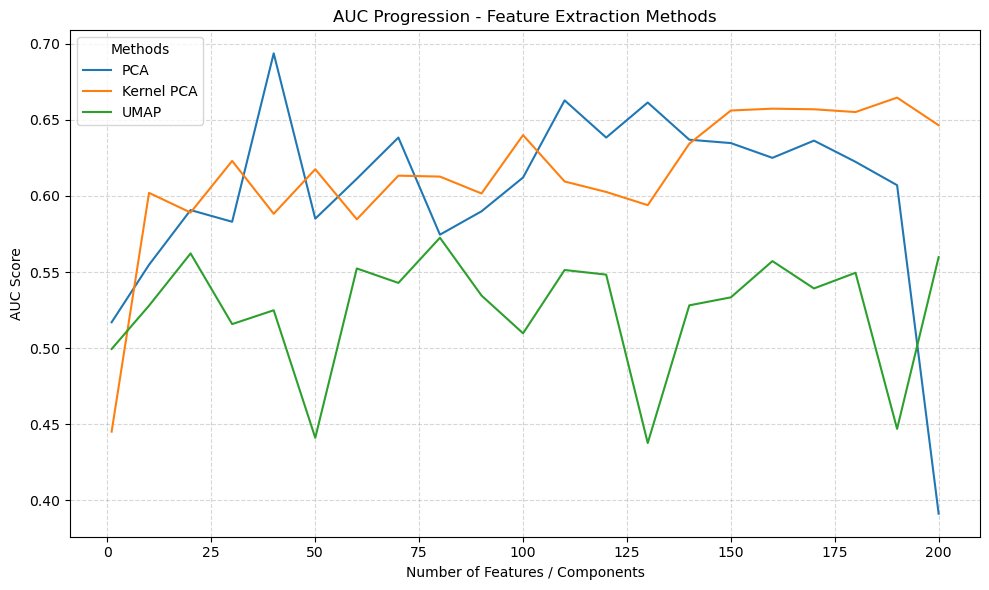

In [10]:
def plot_auc_progression(df, title):
    plt.figure(figsize=(10, 6))

    for method in df.index.get_level_values(1).unique():
        auc_values = df.xs(method, level=1)['AUC']
        plt.plot(df.xs(method, level=1).index, auc_values, label=method)

    plt.title(title)
    plt.xlabel('Number of Features / Components')
    plt.ylabel('AUC Score')
    plt.legend(title='Methods')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_auc_progression(df_feature_selection, "AUC Progression - Feature Selection Methods")

plot_auc_progression(df_feature_extraction, "AUC Progression - Feature Extraction Methods")